In [46]:
import os

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models, transforms
from early_stopping import EarlyStopping
from dataset.dataset import CrackDataset, DatasetType, SubSampCrackDataset
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, RocCurveDisplay

from dotenv import load_dotenv

from visualisation_utils import plot_classification_results

In [2]:
load_dotenv()

True

In [3]:
labels_df = pd.read_csv(os.path.join(os.environ['DATA_FOLDER'], 'subsampled_df.csv'), index_col=0)
labels_df

name  anomaly  probability
0     12574        0     0.000000
1      7595        0     0.000796
2      7404        0     0.000000
3     13159        0     0.000990
4     12932        0     0.000466
...     ...      ...          ...
9995   7228        1     0.016515
9996   3775        1     0.054726
9997  12792        1     0.015176
9998  14134        1     0.012459
9999  13136        1     0.032292

[10000 rows x 3 columns]

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])
aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])

In [7]:
dataset = SubSampCrackDataset(os.environ['DATA_FOLDER'], labels_df, DatasetType.TRAIN, sub_transform=aug_transform, maj_transform=transform)


In [6]:
# dataset.labels = labels_df.anomaly.to_list()
# dataset.labels_legend = ['normal', 'anomaly']

In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
train_dataset[0]

(tensor([[[0.7294, 0.7333, 0.7451,  ..., 0.6941, 0.6902, 0.6863],
          [0.7176, 0.7176, 0.7333,  ..., 0.6941, 0.6941, 0.6980],
          [0.7098, 0.7059, 0.7216,  ..., 0.6745, 0.6784, 0.6824],
          ...,
          [0.7922, 0.7804, 0.7608,  ..., 0.6588, 0.6549, 0.6510],
          [0.7922, 0.7804, 0.7608,  ..., 0.6667, 0.6627, 0.6588],
          [0.7922, 0.7804, 0.7608,  ..., 0.6745, 0.6706, 0.6667]],
 
         [[0.7255, 0.7294, 0.7412,  ..., 0.6980, 0.6941, 0.6902],
          [0.7137, 0.7137, 0.7294,  ..., 0.6980, 0.6980, 0.7020],
          [0.7059, 0.7020, 0.7176,  ..., 0.6784, 0.6824, 0.6863],
          ...,
          [0.7882, 0.7765, 0.7569,  ..., 0.6588, 0.6549, 0.6510],
          [0.7882, 0.7765, 0.7569,  ..., 0.6667, 0.6627, 0.6588],
          [0.7882, 0.7765, 0.7569,  ..., 0.6745, 0.6706, 0.6667]],
 
         [[0.7059, 0.7098, 0.7216,  ..., 0.6667, 0.6627, 0.6588],
          [0.6941, 0.6941, 0.7098,  ..., 0.6667, 0.6667, 0.6706],
          [0.6863, 0.6824, 0.6980,  ...,

In [10]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
device='cuda'
model = models.alexnet()
num_classes = len(dataset.labels_legend)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

In [13]:
w2 = sum(dataset.labels)
w1 = len(dataset.labels) - w2
torch.Tensor([w1 / w1, w1 / w1])

tensor([1., 1.])

In [14]:
w1, w2

(5000, 5000)

In [15]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([w1 / w1, w1 / w1]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
num_epochs = 500
early_stopper = EarlyStopping(patience=10, verbose=True, path='models/weighted/best_alexnet.pth')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f} "
          f"Val Loss: {avg_val_loss:.4f} "
          f"Val Acc: {val_accuracy:.4f}%")

    # early stopping
    early_stopper(avg_val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break

# Load the best model after training
early_stopper.load_best(model)
print("Training complete. Best model loaded.")


Epoch 1/500 Train Loss: 1.1521 Val Loss: 0.6947 Val Acc: 48.9000%
Validation loss improved (inf --> 0.6947). Saving model...
Epoch 2/500 Train Loss: 0.7053 Val Loss: 0.6924 Val Acc: 51.1000%
Validation loss improved (0.6947 --> 0.6924). Saving model...
Epoch 3/500 Train Loss: 0.6933 Val Loss: 0.6915 Val Acc: 51.4000%
Validation loss improved (0.6924 --> 0.6915). Saving model...
Epoch 4/500 Train Loss: 0.6934 Val Loss: 0.6911 Val Acc: 68.4500%
Validation loss improved (0.6915 --> 0.6911). Saving model...
Epoch 5/500 Train Loss: 0.6956 Val Loss: 0.6932 Val Acc: 48.9000%
EarlyStopping counter: 1/10
Epoch 6/500 Train Loss: 0.6929 Val Loss: 0.6906 Val Acc: 51.6500%
Validation loss improved (0.6911 --> 0.6906). Saving model...
Epoch 7/500 Train Loss: 0.6920 Val Loss: 0.6852 Val Acc: 49.0000%
Validation loss improved (0.6906 --> 0.6852). Saving model...
Epoch 8/500 Train Loss: 0.7397 Val Loss: 0.6928 Val Acc: 51.1000%
EarlyStopping counter: 1/10
Epoch 9/500 Train Loss: 0.6934 Val Loss: 0.6882

# Test

In [68]:
test_ds = CrackDataset(os.environ["DATA_FOLDER"], DatasetType.EVAL_UNBALANCED, transform=transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [69]:
y_true = []
y_pred = []
y_probas = []

with torch.no_grad():
    model.eval()

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted.squeeze().detach().cpu())
        y_true.append(labels.squeeze().detach().cpu())
        y_probas.append(torch.softmax(outputs.squeeze(), 0).detach().cpu()[1])


In [31]:
sum([int(i) for i in y_true])

30

In [32]:
y_probas

[tensor(0.4418),
 tensor(0.5097),
 tensor(0.4255),
 tensor(0.4907),
 tensor(0.5610),
 tensor(0.4370),
 tensor(0.4374),
 tensor(0.4363),
 tensor(0.4204),
 tensor(0.4466),
 tensor(0.4540),
 tensor(0.5683),
 tensor(0.5683),
 tensor(0.5029),
 tensor(0.4776),
 tensor(0.4140),
 tensor(0.4121),
 tensor(0.4431),
 tensor(0.4612),
 tensor(0.4980),
 tensor(0.4751),
 tensor(0.4250),
 tensor(0.4142),
 tensor(0.4420),
 tensor(0.5620),
 tensor(0.4326),
 tensor(0.4588),
 tensor(0.6077),
 tensor(0.4534),
 tensor(0.4990),
 tensor(0.4287),
 tensor(0.4893),
 tensor(0.4783),
 tensor(0.4157),
 tensor(0.4249),
 tensor(0.4404),
 tensor(0.4965),
 tensor(0.4119),
 tensor(0.4451),
 tensor(0.4825),
 tensor(0.4228),
 tensor(0.4643),
 tensor(0.4753),
 tensor(0.4271),
 tensor(0.4701),
 tensor(0.4352),
 tensor(0.5155),
 tensor(0.4473),
 tensor(0.4142),
 tensor(0.4588),
 tensor(0.4250),
 tensor(0.4234),
 tensor(0.4259),
 tensor(0.4306),
 tensor(0.4210),
 tensor(0.4500),
 tensor(0.4838),
 tensor(0.5961),
 tensor(0.4576

In [33]:
pd.DataFrame(confusion_matrix(test_ds.labels, y_pred, ),).style.background_gradient(axis='columns')

In [34]:
print('F1 average: ', f1_score(test_ds.labels, y_pred))
print('F1 weighted: ', f1_score(test_ds.labels, y_pred, average='weighted'))

F1 average:  0.25892857142857145
F1 weighted:  0.8871034427284427


In [71]:
accuracy_score(test_ds.labels, y_pred, )

0.834

In [35]:
roc_c = roc_curve(test_ds.labels, y_probas, pos_label=1, drop_intermediate=False)
roc_auc = auc(x=roc_c[0], y=roc_c[1])

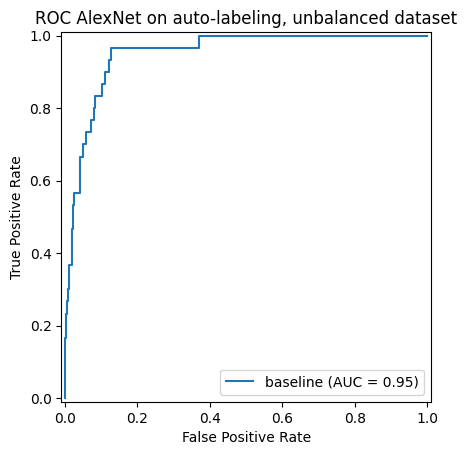

In [37]:
display = RocCurveDisplay(fpr=roc_c[0], tpr=roc_c[1], roc_auc=roc_auc, estimator_name='baseline')
display.plot()
plt.title('ROC AlexNet on auto-labeling, unbalanced dataset')
plt.show()

## Balanced

In [73]:
test_b_ds = CrackDataset(os.environ["DATA_FOLDER"], DatasetType.EVAL_BALANCED, transform=transform)
test_b_loader = DataLoader(test_b_ds, batch_size=1, shuffle=False)

In [74]:
y_true = []
y_pred = []
y_probas = []

with torch.no_grad():
    model.eval()

    for images, labels in test_b_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted.squeeze().detach().cpu())
        y_true.append(labels.squeeze().detach().cpu())
        y_probas.append(torch.softmax(outputs.squeeze(), 0).detach().cpu()[1])


In [40]:
sum([int(i) for i in y_true])

1000

In [42]:
pd.DataFrame(confusion_matrix(test_b_ds.labels, y_pred, ),).style.background_gradient(axis='columns')

In [43]:
print('F1 average: ', f1_score(test_b_ds.labels, y_pred))
print('F1 weighted: ', f1_score(test_b_ds.labels, y_pred, average='weighted'))

F1 average:  0.8959318826868495
F1 weighted:  0.8896414450549837


In [76]:
accuracy_score(test_b_ds.labels, y_pred, )

0.89

In [44]:
roc_c = roc_curve(test_b_ds.labels, y_probas, pos_label=1, drop_intermediate=False)
roc_auc = auc(x=roc_c[0], y=roc_c[1])

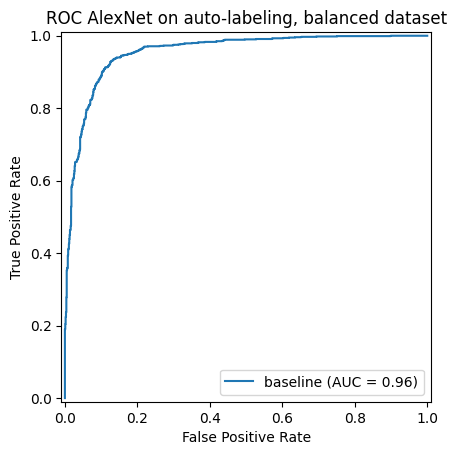

In [45]:
display = RocCurveDisplay(fpr=roc_c[0], tpr=roc_c[1], roc_auc=roc_auc, estimator_name='baseline')
display.plot()
plt.title('ROC AlexNet on auto-labeling, balanced dataset')
plt.show()

In [61]:
def plot_classification_results(paths_of_images, y_true, y_pred, number_of_images, result_type, y_proba=None):
    import matplotlib.image as mpimg
    """
    Plots images that match a given classification result type (TP, FP, TN, FN).

    Args:
        paths_of_images (list): List of paths to images.
        y_true (list): Ground truth labels.
        y_pred (list): Predicted labels.
        number_of_images (int): Number of images to plot.
        result_type (str): One of {'true_positive', 'false_positive', 'true_negative', 'false_negative'}.
        :param y_proba: list of probabilities of the anomaly
    """
    assert result_type in {'true_positive', 'false_positive', 'true_negative', 'false_negative'}, \
        "Invalid result_type. Must be one of 'true_positive', 'false_positive', 'true_negative', 'false_negative'."

    # Identify indices for each type
    matched_indices = []
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        if result_type == 'true_positive' and true == 1 and pred == 1:
            matched_indices.append(i)
        elif result_type == 'false_positive' and true == 0 and pred == 1:
            matched_indices.append(i)
        elif result_type == 'true_negative' and true == 0 and pred == 0:
            matched_indices.append(i)
        elif result_type == 'false_negative' and true == 1 and pred == 0:
            matched_indices.append(i)

    # Limit to the number requested
    matched_indices = matched_indices[:number_of_images]
    n_images = len(matched_indices)

    if n_images == 0:
        print(f"No images found for result_type '{result_type}'")
        return

    n_cols = (n_images + 1) // 2
    fig, axs = plt.subplots(2, n_cols, figsize=(4 * n_cols, 8))
    axs = axs.flatten()

    for idx, img_idx in enumerate(matched_indices):
        img_path = paths_of_images[img_idx]
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        image = mpimg.imread(img_path)
        axs[idx].imshow(image)
        prob_in_title = f"Anom Conf: {round(y_proba[img_idx], 2)}" if y_proba else ""
        axs[idx].set_title(f"True: {y_true[img_idx]}, Pred: {y_pred[img_idx]}" +
                           prob_in_title)
        axs[idx].axis('off')

    # Hide unused subplots
    for j in range(len(matched_indices), len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()




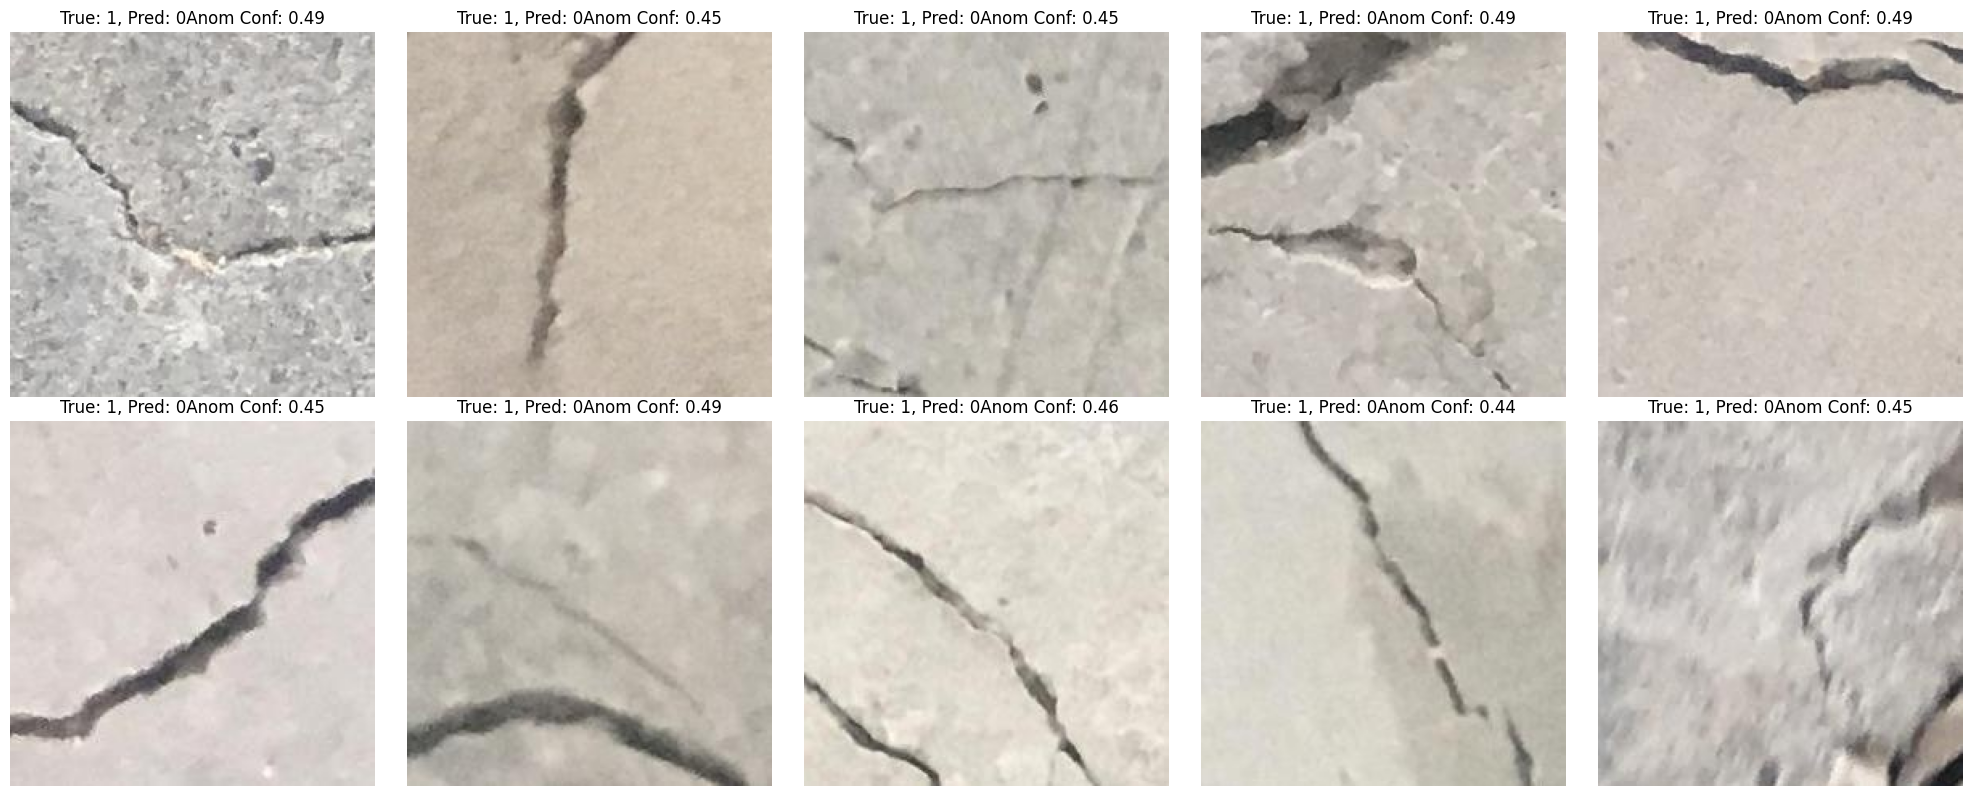

In [62]:
plot_classification_results(test_b_ds.data, test_b_ds.labels, y_pred, 10, 'false_negative', list(map(float, y_probas)))

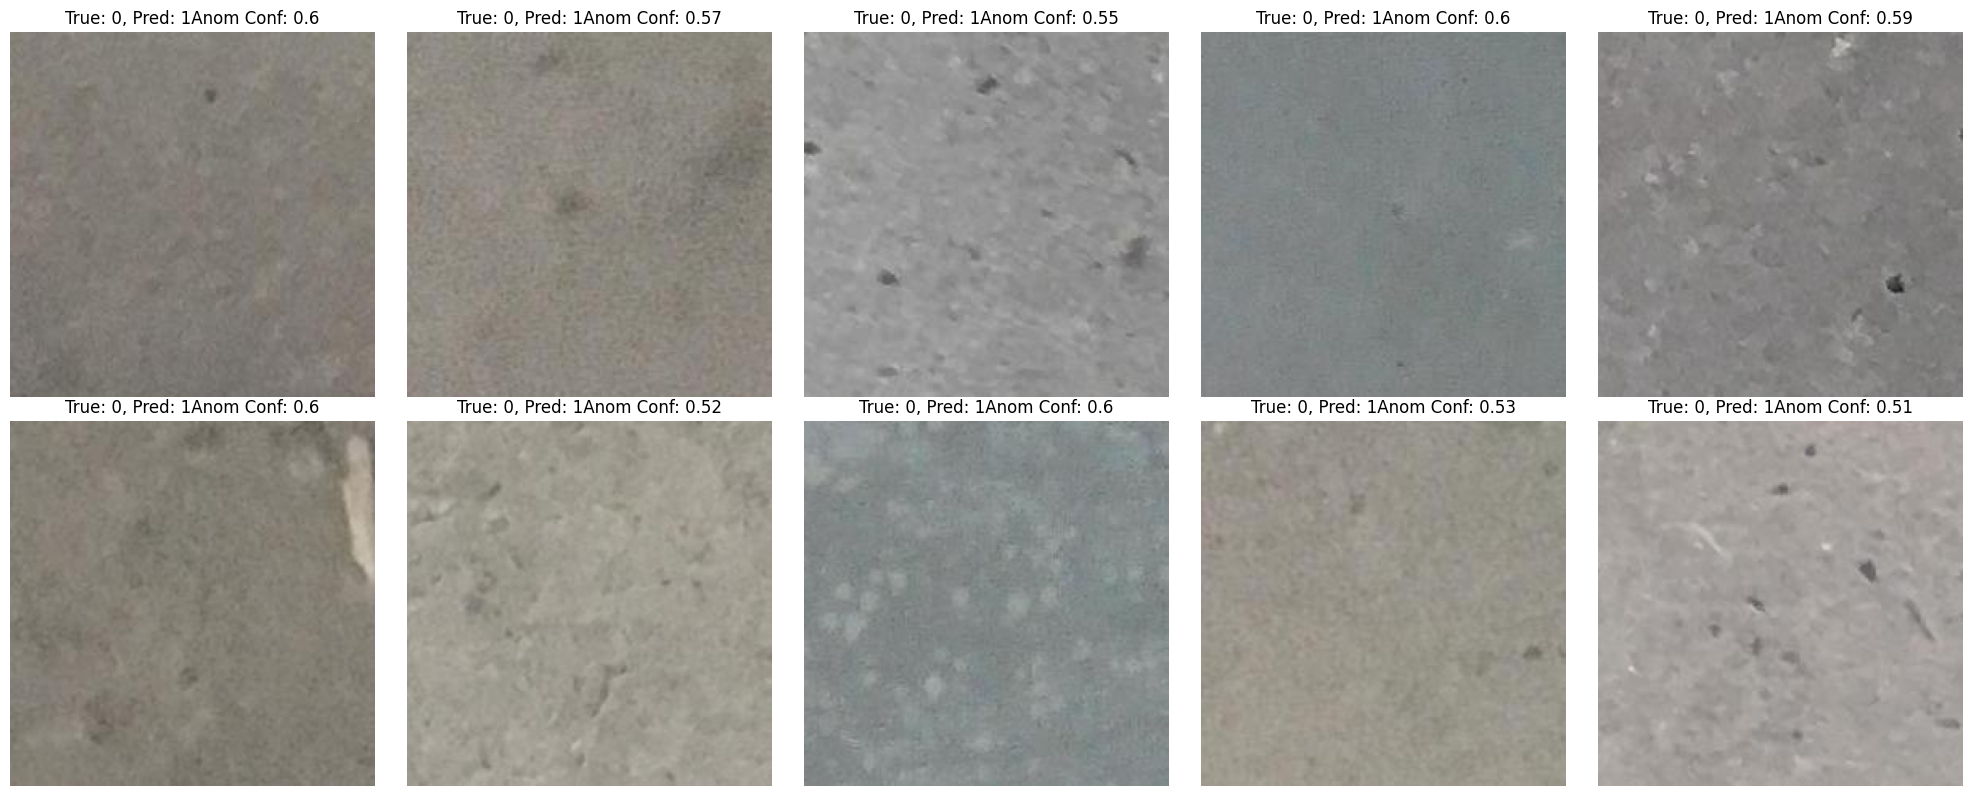

In [64]:
plot_classification_results(test_b_ds.data, test_b_ds.labels, y_pred, 10, 'false_positive', list(map(float, y_probas)))

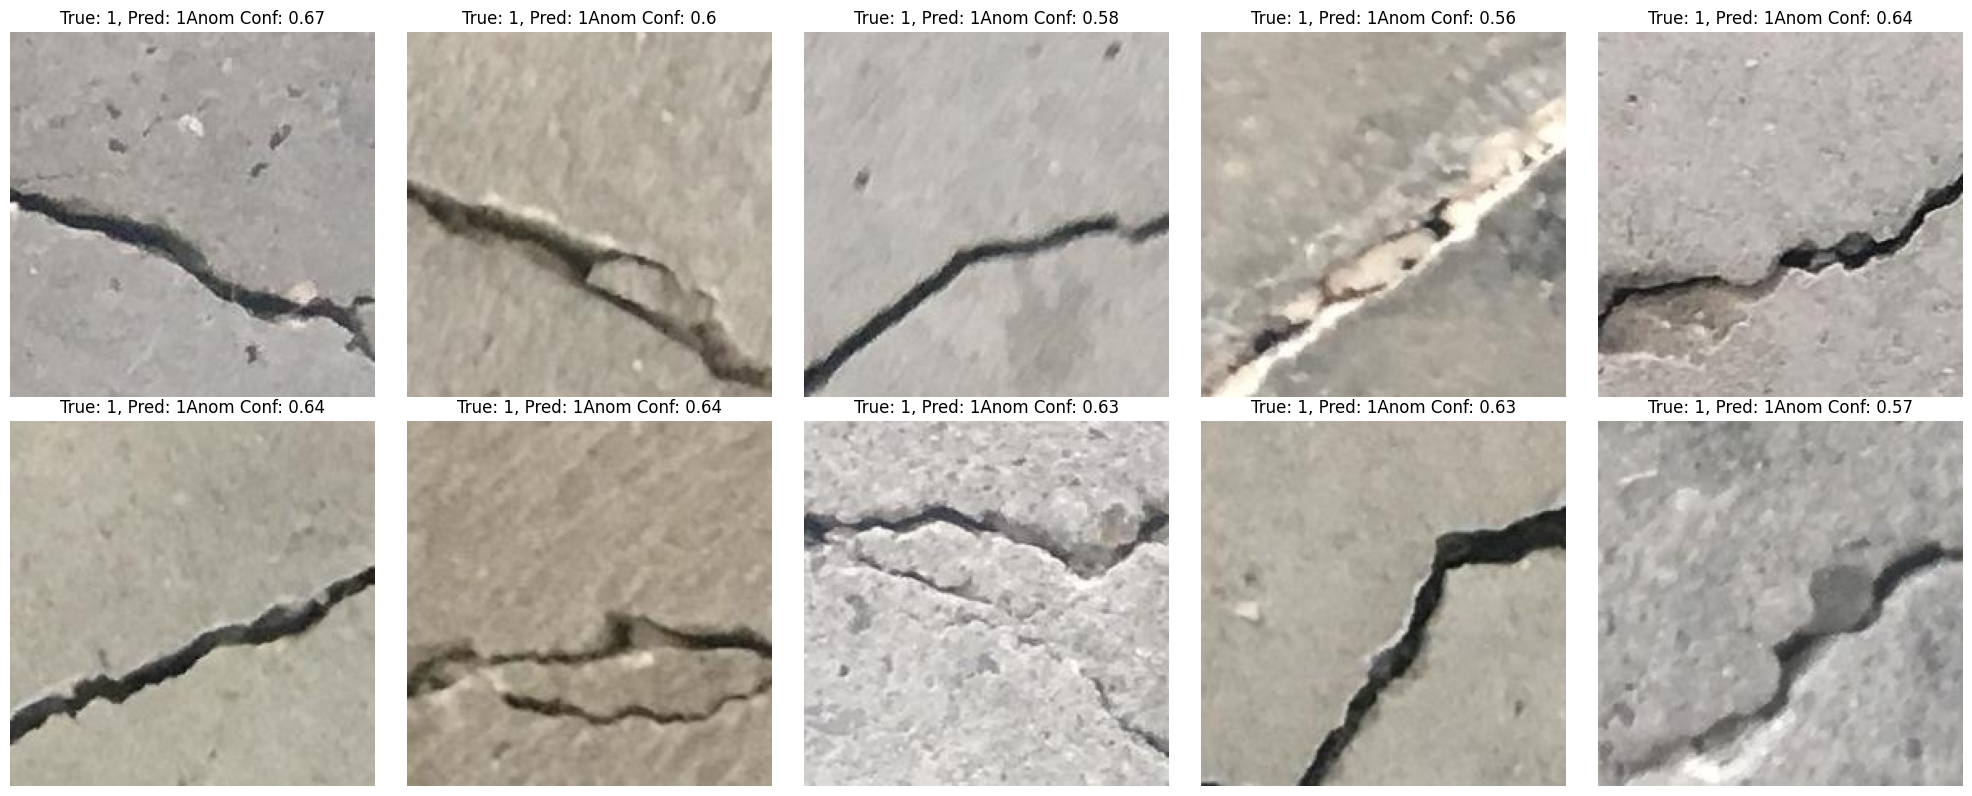

In [65]:
plot_classification_results(test_b_ds.data, test_b_ds.labels, y_pred, 10, 'true_positive', list(map(float, y_probas)))

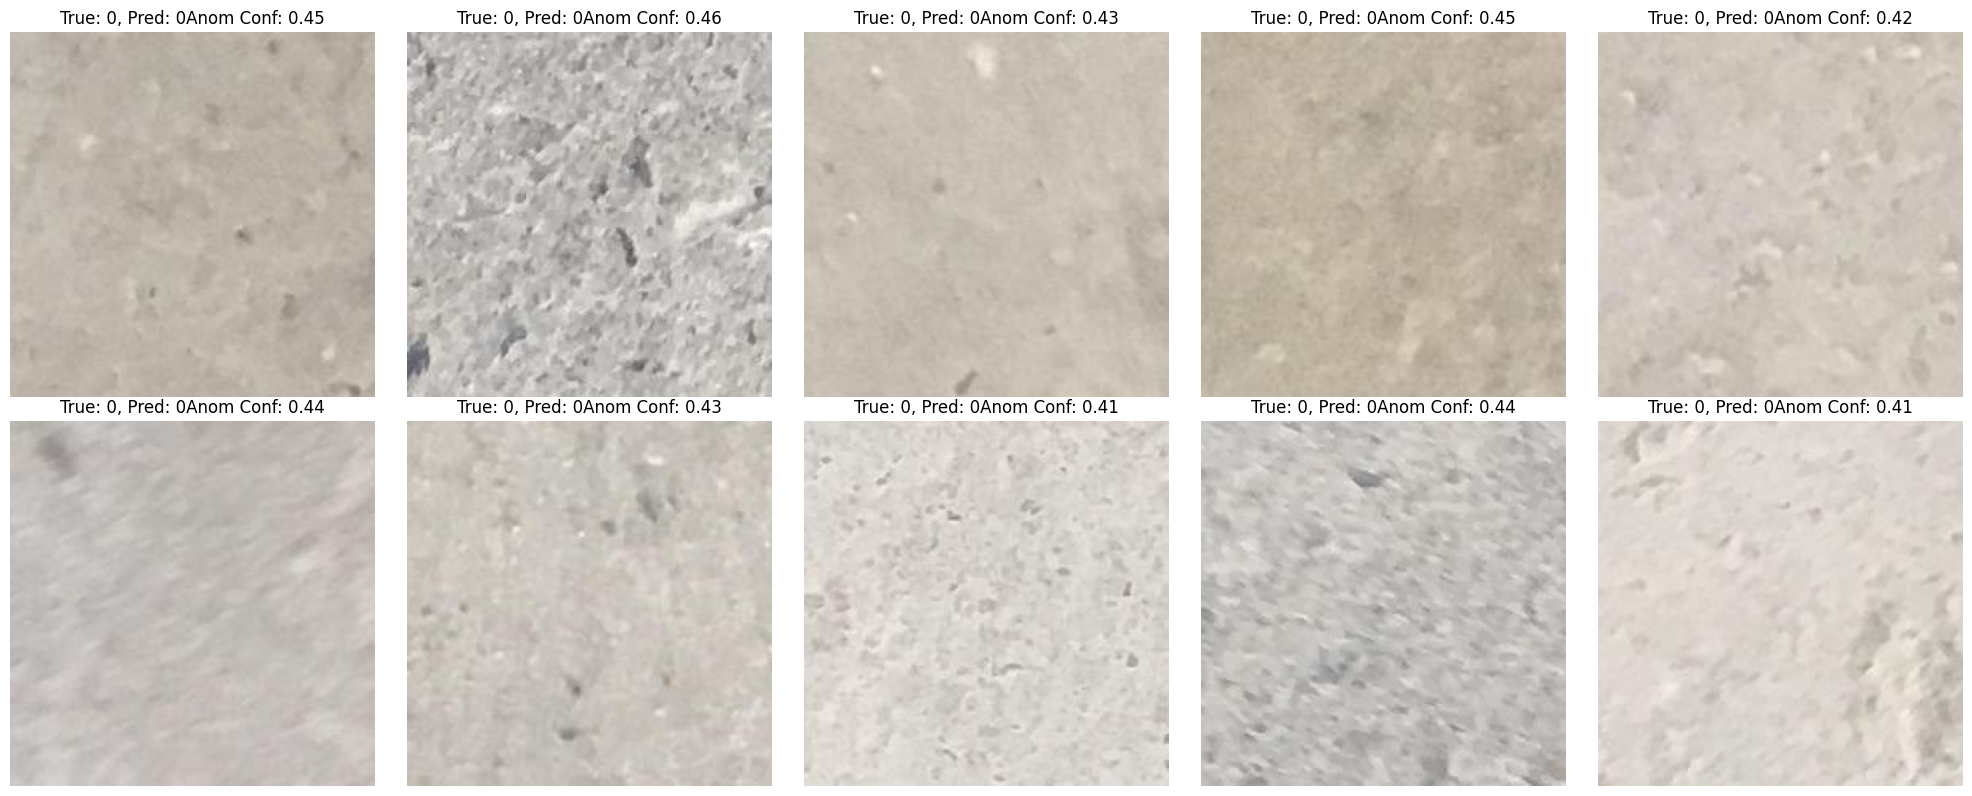

In [66]:
plot_classification_results(test_b_ds.data, test_b_ds.labels, y_pred, 10, 'true_negative', list(map(float, y_probas)))